In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['keras-pretrained-models', 'state-farm-distracted-driver-detection']


In [2]:
from keras import layers
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from os import listdir, makedirs
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers, regularizers

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
RESOLUTION = 150
BATCH_SIZE=64

#if you need data augmentation processing
#train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #validation_split=0.3)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
        "../input/state-farm-distracted-driver-detection/train/",
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training")

val_generator = val_datagen.flow_from_directory(
        "../input/state-farm-distracted-driver-detection/train/",
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation")

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


In [18]:
path = "../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
conv_base = VGG16(include_top=False, input_shape=(150, 150, 3), weights=path) 

In [20]:
def vgg16_pretrained_model(model_vgg, dropout_=False, regularizer_=False, regularizer_weight=0.001):
  
    model = Sequential()
    model.add(model_vgg)
    model.add(Flatten())
    if dropout_:
        model.add(Dropout(0.5))
    if regularizer_:
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight,
                                                                                            l2=regularizer_weight)))
    else:
        model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

    return model

In [21]:
model = vgg16_pretrained_model(conv_base, dropout_=False, regularizer_=False, regularizer_weight=0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 16,814,666
Trainable params: 16,814,666
Non-trainable params: 0
_________________________________________________________________


In [30]:
N_TRAIN = 15702
N_VAL = 6722
history = model.fit_generator(
        train_generator,
        steps_per_epoch=(N_TRAIN // BATCH_SIZE),
        epochs=20,
        validation_data=val_generator,
        validation_steps=(N_VAL // BATCH_SIZE) 
    )
    

Epoch 1/20
2/2 [==============================] - 3s 2s/step - loss: 1.8268 - acc: 0.4531 - val_loss: 1.7395 - val_acc: 0.4062
Epoch 2/20
2/2 [==============================] - 3s 1s/step - loss: 1.6258 - acc: 0.5547 - val_loss: 1.6473 - val_acc: 0.5312
Epoch 3/20
2/2 [==============================] - 3s 1s/step - loss: 1.6252 - acc: 0.4766 - val_loss: 1.5846 - val_acc: 0.4844
Epoch 4/20
2/2 [==============================] - 3s 1s/step - loss: 1.5449 - acc: 0.6016 - val_loss: 1.4503 - val_acc: 0.5781
Epoch 5/20
2/2 [==============================] - 2s 1s/step - loss: 1.5278 - acc: 0.5703 - val_loss: 1.4263 - val_acc: 0.6250
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 1.3138 - acc: 0.6875 - val_loss: 1.2375 - val_acc: 0.6562
Epoch 7/20
2/2 [==============================] - 2s 1s/step - loss: 1.1396 - acc: 0.7344 - val_loss: 1.2310 - val_acc: 0.6406
Epoch 8/20
2/2 [==============================] - 2s 1s/step - loss: 1.1393 - acc: 0.7109 - val_loss: 1.0844 - 

In [31]:
history.params

{'do_validation': True,
 'epochs': 20,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'steps': 2,
 'verbose': 1}

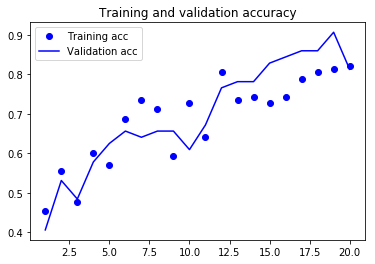

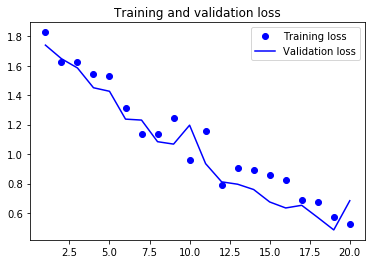

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

In [ ]:
def build_vgg16_pretrained_fine_tunning(first_trainable_layer='block5_conv3',
                                       with_dropout=False,
                                       with_regularizer=False,
                                       regularizer_weight=0.001):
    conv_base = model_vgg16(name='VGG16',freeze_conv=False)
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == first_trainable_layer:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    if with_dropout:
        model.add(Dropout(0.5))
    if with_regularizer:
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight,
                                                                                            l2=regularizer_weight)))
    else:
        model.add(Dense(256, activation='relu'))
    model.add(Dense(249, activation='softmax')) # for multiclass single-label classification
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc']) # low learn. rate
    
    return model